## **Loading Data**
---

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns

In [40]:
# define input features
index = ["ProgId", "InputId", "ConfigId"]

mem_features = ["Mem_Latency", "L1_Sets", "L1_Latency",
                "L2_Sets","L2_Latency",]

program_features = ["L1_Hits_1Thread", "L1_Misses_1Thread", "L2_Hits_1Thread", "L2_Misses_1Thread", "L3_Hits_1Thread", "L3_Misses_1Thread",
                    "Instructions", "BranchPredictionAccuracy_1Thread", "pThreads"]

input_features = mem_features + program_features

target = "SpeedUp"


In [41]:
# load data
data_path = "https://raw.githubusercontent.com/s-rishu/performance-predictor/main/sim_data/stats.csv"
data = pd.read_csv(data_path)

# check data types
print(data.dtypes)

ProgId                                  int64
InputId                                 int64
pThreads                                int64
ConfigId                                int64
Mem_Hits                              float64
Mem_Misses                            float64
Mem_Latency                             int64
L1_Sets                                 int64
L1_Latency                              int64
L1_Hits                               float64
L1_Misses                             float64
L2_Sets                                 int64
L2_Latency                              int64
L2_Hits                               float64
L2_Misses                               int64
L3_Hits                               float64
L3_Misses                             float64
Instructions                            int64
InstructionsPerSecond                   int64
SimTime                               float64
Cycles                                  int64
CyclesPerSecond                   

## **Calculate SpeedUp**
---

In [42]:
# calculate speedup for each row
data["SpeedUp"] = data.groupby(index)['SimTime'].transform(lambda x: x / x[data['pThreads'] == 1].values[0])

data["L1_Hits_1Thread"] = data.groupby(index)['L1_Hits'].transform(lambda x: x[data['pThreads'] == 1].values[0])
data["L1_Misses_1Thread"] = data.groupby(index)['L1_Misses'].transform(lambda x: x[data['pThreads'] == 1].values[0])

data["L2_Hits_1Thread"] = data.groupby(index)['L2_Hits'].transform(lambda x: x[data['pThreads'] == 1].values[0])
data["L2_Misses_1Thread"] = data.groupby(index)['L2_Misses'].transform(lambda x: x[data['pThreads'] == 1].values[0])

data["L3_Hits_1Thread"] = data.groupby(index)['L3_Hits'].transform(lambda x: x[data['pThreads'] == 1].values[0])
data["L3_Misses_1Thread"] = data.groupby(index)['L3_Misses'].transform(lambda x: x[data['pThreads'] == 1].values[0])

data["BranchPredictionAccuracy_1Thread"] = data.groupby(index)['BranchPredictionAccuracy'].transform(lambda x: x[data['pThreads'] == 1].values[0])

# drop columns that are no longer needed
data = data[input_features + [target]]
print(data.head(10))

   Mem_Latency  L1_Sets  L1_Latency  L2_Sets  L2_Latency  L1_Hits_1Thread  \
0          200       64           3     1024          18          96668.0   
1          200      128           3     1024          25          97302.0   
2          250       64           3     2048          25          96596.0   
3          250      128           4     1024          25          93246.0   
4          300       64           4     2048          25          92711.0   
5          200       64           3     1024          18          96668.0   
6          200      128           3     1024          25          97302.0   
7          250       64           3     2048          25          96596.0   
8          250      128           4     1024          25          93246.0   
9          300       64           4     2048          25          92711.0   

   L1_Misses_1Thread  L2_Hits_1Thread  L2_Misses_1Thread  L3_Hits_1Thread  \
0             3607.0           2095.0                  0              0.0  

## **Feature Selection**
---

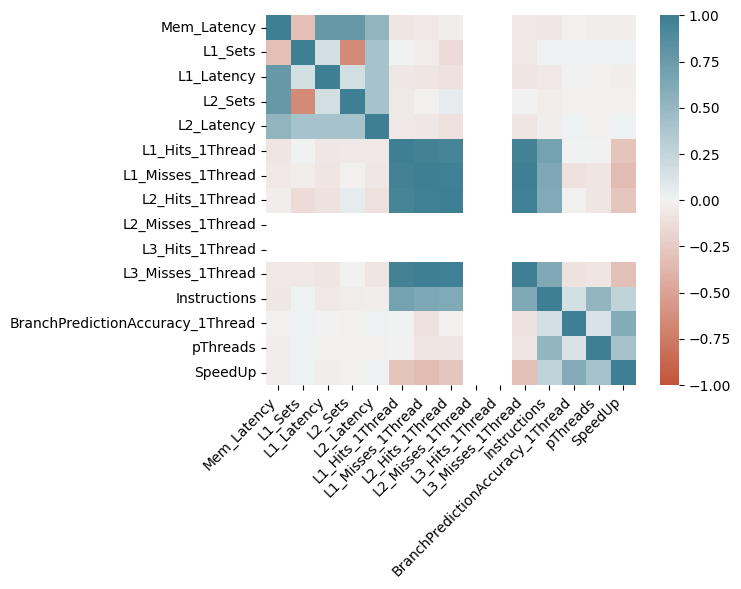

In [43]:
#exploring useful features through correlation matrix
corr = data.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# TODO: remove features if needed
# print("Final modelling attributes along with target variable:\n\n")
# print(data.dtypes)


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error


## **Splitting the dataset for training and testing**
---

In [58]:
#splitting into training and test sets
from sklearn.model_selection import train_test_split
#shuffle data
data = data.sample(frac = 1)
Y = data[target]
X = data.drop(columns=[target])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=39)

## **Exploring Linear Regression**
---

In [59]:
# train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

In [60]:
# test the linear regression model
Y_pred = lr_model.predict(X_test)

# get maximum residual error
print("Maximum Residual Error: {}".format(max_error(Y_test, Y_pred)))

# get mean squared error
print("Mean Squared Error: {}".format(mean_squared_error(Y_test, Y_pred)))

# get mean absolute error
print("Mean Absolute Error: {}".format(mean_absolute_error(Y_test, Y_pred)))

#check accuracy percentage with absolute prediction error <0.5
absolute_error = abs(Y_test - Y_pred)
within_range_count = sum(absolute_error <= 0.5)
percentage_within_range = (within_range_count / len(Y_test)) * 100

print(f"Percentage of Y_pred values with prediction error within +0.5 to -0.5: {percentage_within_range:.2f}%")


Maximum Residual Error: 1.7347916071812435
Mean Squared Error: 0.29448166260542197
Mean Absolute Error: 0.38991120792824796
Percentage of Y_pred values with prediction error within +0.5 to -0.5: 72.73%


## **Exploring Decision Tree Regression**
---

In [61]:
# train the decesion tree regression model
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, Y_train)

DecisionTreeRegressor()

In [ ]:
# test the decesion tree regression model
Y_pred = dtr_model.predict(X_test)

# get maximum residual error
print("Maximum Residual Error: {}".format(max_error(Y_test, Y_pred)))

# get mean squared error
print("Mean Squared Error: {}".format(mean_squared_error(Y_test, Y_pred)))

# get mean absolute error
print("Mean Absolute Error: {}".format(mean_absolute_error(Y_test, Y_pred)))

#check accuracy percentage with absolute prediction error <0.5
absolute_error = abs(Y_test - Y_pred)
within_range_count = sum(absolute_error <= 0.5)
percentage_within_range = (within_range_count / len(Y_test)) * 100

print(f"Percentage of Y_pred values with prediction error within +0.5 to -0.5: {percentage_within_range:.2f}%")

## **Conclusion**
---
#TODO
